In [185]:
import numpy  as np
import sympy  as sym

import matplotlib.pyplot as plt
import scipy.sparse      as sparse

import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.bsplines   as bsp
import utilitis_FEEC.Bspline    as bspline

import utilitis_FEEC.projections_mhd as mhd
import utilitis_FEEC.projectors_opt  as proj
import utilitis_FEEC.derivatives     as der

import utilitis_FEEC.mass_matrices_stencil as mass

In [395]:
Nel = [2, 2, 128]            # mesh generation on logical domain
bc  = [True, True, True]     # boundary conditions
p   = [2, 2, 3]              # splines degrees




el_b     = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                           # breakpoints
T        = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]       # knot vectors
Nbase    = [(Nel + p) for Nel, p in zip(Nel, p)]                                   # number of basis functions
greville = [(bsp.greville(T, p, bc) + p%2*1e-15) for T, p, bc in zip(T, p, bc)]    # greville points
mapping  = 'cube'                                                                  # geometry






if mapping == 'annulus':
    
    # ... coordinates
    r, phi, z = sym.symbols('r, phi, z')
    q = sym.Matrix([r, phi, z])
    
    # ... mapping
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(r*dR + R1)*sym.cos(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*phi), z])
    
elif mapping == 'torus':
    
    # ... coordinates
    r, theta, phi = sym.symbols('r, theta, phi')
    q = sym.Matrix([r, theta, phi])

    # ... mapping
    R0 = 1.5         # major radius
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.cos(2*sym.pi*phi), (R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.sin(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*theta)])
    
elif mapping == 'cube':
    
    # ... coordinates
    x, y, z = sym.symbols('x, y, z')
    q = sym.Matrix([x, y, z])
    
    # ... mapping
    Lx = 1.           # length in x
    Ly = 1.           # length in y
    Lz = 20.          # length in z
    
    F = sym.Matrix([Lx*x, Ly*y, Lz*z])
    

# ... jacobian matrix
DF = F.jacobian(q)

# ... metric tensor
G = sym.simplify(DF.transpose()*DF)

# ... inverse of metric tensor
Ginv = G.inverse()

#... square root of jacobi determinant
g = sym.simplify(G.det())
g_sqrt = sym.sqrt(g)


# ... convert mapping functions to callables
xc = sym.lambdify(q, F[0])
yc = sym.lambdify(q, F[1])
zc = sym.lambdify(q, F[2])

G      = [[sym.lambdify(q, G[0, 0]), sym.lambdify(q, G[0, 1]), sym.lambdify(q, G[0, 2])], [sym.lambdify(q, G[1, 0]), sym.lambdify(q, G[1, 1]), sym.lambdify(q, G[1, 2])], [sym.lambdify(q, G[2, 0]), sym.lambdify(q, G[2, 1]), sym.lambdify(q, G[2, 2])]]
Ginv   = [[sym.lambdify(q, Ginv[0, 0]), sym.lambdify(q, Ginv[0, 1]), sym.lambdify(q, Ginv[0, 2])], [sym.lambdify(q, Ginv[1, 0]), sym.lambdify(q, Ginv[1, 1]), sym.lambdify(q, Ginv[1, 2])], [sym.lambdify(q, Ginv[2, 0]), sym.lambdify(q, Ginv[2, 1]), sym.lambdify(q, Ginv[2, 2])]]
g      = sym.lambdify(q, g)
g_sqrt = sym.lambdify(q, g_sqrt)


# ... physical input parameters for homogeneous equlibrium
r0 = 1.
p0 = 1.
B01 = 0.
B02 = 1.
B03 = 0.

rho0 = lambda q1, q2, q3 : r0 * np.ones(q1.shape)     # ... eq. mass density of plasma
pr0  = lambda q1, q2, q3 : p0 * np.ones(q1.shape)     # ... eq. pressure of plasma

B0_1 = lambda q1, q2, q3 : B01 * np.ones(q1.shape)    # ... background magnetic field in 1 - direction
B0_2 = lambda q1, q2, q3 : B02 * np.ones(q1.shape)    # ... background magnetic field in 2 - direction
B0_3 = lambda q1, q2, q3 : B03 * np.ones(q1.shape)    # ... background magnetic field in 3 - direction
B0   = [B0_1, B0_2, B0_3]

gamma = 5/3                                           # ... adiabatic exponent
cs = np.sqrt(gamma*p0/r0)                             # ... speed of sound
vA = np.sqrt((B01**2 + B02**2 + B03**2)/r0)           # ... Alfvén-velocity



# ... dispersion relations
def omegaM(k, pol):
    
    delta = (4*B03**2*cs**2*vA**2)/((cs**2 + vA**2)**2*(B01**2 + B02**2 + B03**2))
    
    return np.sqrt(1/2*k**2*(cs**2 + vA**2)*(1 + pol*np.sqrt(1 - delta)))

def omegaS(k):
    return vA*k*np.sqrt(B03/np.sqrt(B01**2 + B02**2 + B03**2))
# ...



# ... initial conditions
amp = 0.1                                             # ... characteristic amplitude of pertubations
kz  = 2                                               # ... wavenumber of initial pertubation
w   = omegaM(kz, +1)                                  # ... frequency of wave
vph = w/kz                                            # ... phase velocity


"""
u1_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
u2_ini = lambda q1, q2, q3 : amp * np.sin(2*np.pi*kz*q3)
u3_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)

B1_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
B2_ini = lambda q1, q2, q3 : -kz*B03/w * amp * np.sin(2*np.pi*kz*q3)
B3_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)

rh_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
pr_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
"""

Nmodes = 40

modesz = np.linspace(0, Nmodes, Nmodes + 1) - Nmodes/2
modesz = np.delete(modesz, int(Nmodes/2))
amps   = np.random.rand(8, Nmodes)

def u1_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[0, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def u2_ini(q1, q2, q3):
    
    values = np.zeros(q2.shape)
    
    for i in range(Nmodes):
        values += amps[1, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def u3_ini(q1, q2, q3):
    
    values = np.zeros(q3.shape)
    
    for i in range(Nmodes):
        values += amps[2, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values



def B1_ini(q1, q2, q3):
    
    values = np.zeros(q2.shape)
    
    for i in range(Nmodes):
        values += amps[3, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def B2_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[4, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def B3_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += 0*np.sin(2*np.pi*modesz[i]*q3)
        
    return values


def rh_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[6, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values


def pr_ini(q1, q2, q3):
    
    values = 0.
    
    for i in range(Nmodes):
        values += amps[7, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

In [396]:
vFast  = omegaM(2, +1)/2
vSlow  = omegaM(2, -1)/2
vShear = omegaS(2)/2

In [397]:
MHD = mhd.projections_mhd(p, Nbase, T, bc)

In [398]:
# Right-hand sides of projection matrices
R21_1, R21_2, R21_3 = MHD.assembly_P21(rho0, Ginv)
R11_1, R11_2, R11_3 = MHD.assembly_P11(B0, Ginv)

In [399]:
# Left-hand sides of projectors
PRO = proj.projectors_3d(p, Nbase, T, bc)

PRO.assemble_V0()
PRO.assemble_V1()
PRO.assemble_V2()
PRO.assemble_V3()

In [400]:
# Perform projections of R21
P21_1 = sparse.linalg.spsolve(PRO.interhistopolation_V2_1, R21_1)
P21_2 = sparse.linalg.spsolve(PRO.interhistopolation_V2_2, R21_2)
P21_3 = sparse.linalg.spsolve(PRO.interhistopolation_V2_3, R21_3)

In [401]:
# Perform projections of R11
P11_1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, R11_1)
P11_2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, R11_2)
P11_3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, R11_3)

In [402]:
# block matrices
P21 = sparse.bmat([[P21_1], [P21_2], [P21_3]], format='csr')
P11 = sparse.bmat([[P11_1], [P11_2], [P11_3]], format='csr')

In [403]:
# mass matrices and spaces in V0, V1 and V2
M0     = mass.mass_matrix_V0(p, Nbase, T, g_sqrt, bc)
M1, V1 = mass.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, bc)
M2, V2 = mass.mass_matrix_V2(p, Nbase, T, G, g_sqrt, bc)

In [404]:
# block matrices
from psydac.linalg.block import BlockMatrix

M0 = M0.tosparse().tocsc()
M1 = BlockMatrix(V1, V1, blocks=M1).tosparse().tocsc()
M2 = BlockMatrix(V2, V2, blocks=M2).tosparse().tocsc()

In [405]:
# discrete grad, curl and div
GRAD = der.GRAD_3d(p, Nbase, bc)
CURL = der.CURL_3d(p, Nbase, bc)
DIV  = der.DIV_3d(p, Nbase, bc)

In [406]:
# inverse of M0 and M1
M0inv = sparse.linalg.inv(M0)
M1inv = sparse.linalg.inv(M1)

In [407]:
# system matrix
mat1 = sparse.bmat([[sparse.csr_matrix((Nel[0]*Nel[1]*Nel[2], Nel[0]*Nel[1]*Nel[2])), DIV.dot(P21), None, None], [None, None, M1inv.dot(P11.T.dot(CURL.T.dot(M2))), -GRAD], [None, -CURL.dot(P11), None, None], [None, gamma*M0inv.dot(GRAD.T.dot(M1)), None, None]], format='csc')

In [408]:
# LU factorization of implicit part
dt = 0.05
N = Nel[0]*Nel[1]*Nel[2]


mat1_LU = sparse.linalg.splu(sparse.identity(8*N, format='csc') - dt/2*mat1)

In [409]:
# Explicit part
mat2 = sparse.identity(8*N, format='csc') + dt/2*mat1

In [410]:
def update(rho_vec, u_vec, b_vec, p_vec):
    
    S = np.concatenate((rho_vec, u_vec, b_vec, p_vec))
    
    Snew = mat1_LU.solve(mat2.dot(S))
    
    rhonew = Snew[0:N]
    unew   = Snew[N:4*N]
    bnew   = Snew[4*N:7*N]
    pnew   = Snew[7*N:8*N]
    
    return rhonew, unew, bnew, pnew

In [411]:
# projection of initial conditions
p_vec                  = PRO.PI_0(pr_ini)
u1_vec, u2_vec, u3_vec = PRO.PI_1([u1_ini, u2_ini, u3_ini])
b1_vec, b2_vec, b3_vec = PRO.PI_2([B1_ini, B2_ini, B3_ini])
rho_vec                = PRO.PI_3(rh_ini)

In [412]:
u_vec = np.concatenate((u1_vec, u2_vec, u3_vec))
b_vec = np.concatenate((b1_vec, b2_vec, b3_vec))

S = np.concatenate((rho_vec, u_vec, b_vec, p_vec))

In [413]:
# time integration
Nt = 400
T = Nt*dt

for i in range(Nt):
    rho_vec, u_vec, b_vec, p_vec = update(rho_vec, u_vec, b_vec, p_vec)
    
    S = np.vstack((S, np.concatenate((rho_vec, u_vec, b_vec, p_vec))))

In [414]:
w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/T*w

k = np.linspace(0, Nel[2], Nel[2] + 1) - Nel[2]/2
k = 2*np.pi/Lz*k

In [371]:
uy = S[:, 2*N:3*N]
uy = np.reshape(uy, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [372]:
uykw = np.fft.fft2(np.c_[uy[:, 1, 1, :], uy[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
uykw = np.fft.fftshift(uykw)
uykw_plot = np.abs(uykw)

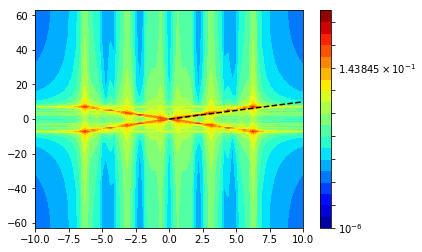

In [373]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, uykw_plot/uykw_plot.max(), cmap = 'jet', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vShear*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))

plt.colorbar()

In [374]:
vShear

1.0

In [415]:
pre = S[:, 7*N:8*N]
pre = np.reshape(pre, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [376]:
prekw = np.fft.fft2(np.c_[pre[:, 1, 1, :], pre[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
prekw = np.fft.fftshift(prekw)
prekw_plot = np.abs(prekw)

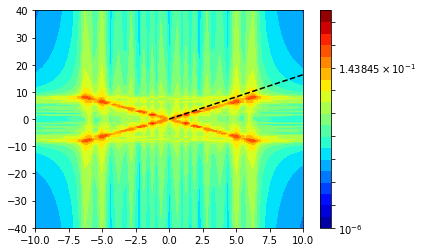

In [418]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, prekw_plot/prekw_plot.max(), cmap = 'jet', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))
plt.ylim((-40, 40))

plt.colorbar()

In [417]:
vFast

1.632993161855452